# Import libraries

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.2MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 
     |████████████████████████████████| 3.3MB 52.8MB/s 


In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
from tqdm import *

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow import keras
from keras import backend as K  #for f1

from transformers import TFDistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizerFast

import matplotlib.pyplot as plt

# Load data

In [3]:
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/dataset/'
X_train = pd.read_csv(root_dir+'train.csv', index_col=0)

train_comment = X_train["comment_text"].values

ValueError: ignored

In [ ]:
X_train

In [4]:
params = {'MAX_LENGTH': 128,
          'EPOCHS': 6,
          'LEARNING_RATE': 5e-5,
          'FT_EPOCHS': 6,
          'OPTIMIZER': 'adam',
          'FT_LEARNING_RATE': 2e-5,
          'BATCH_SIZE': 64,
          'NUM_STEPS': len(X_train.index) // 64,
          'DISTILBERT_DROPOUT': 0.2,
          'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'KERNEL_INITIALIZER': 'GlorotNormal',
          'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.5,          
          'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          'LR_SCHEDULE': '5e-5 for 6 epochs, Fine-tune w/ adam for 6 epochs @2e-5',
          'FREEZING': 'All DistilBERT layers frozen for 6 epochs, then unfrozen for 6',
          'CALLBACKS': '[early_stopping monitoring val_loss w/ patience=0]',
          'RANDOM_STATE':42
          }

# Padding and tokenization

In [5]:
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [6]:
padded_ids_train = []
mask_ids_train = []

for i in tqdm(range(len(train_comment))):
  encoding = tokenizer(str(train_comment[i]), max_length=128 , padding ="max_length", truncation=True)
  input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"] 
  padded_ids_train.append(input_ids)
  mask_ids_train.append(attention_id)

100%|██████████| 159571/159571 [00:48<00:00, 3322.75it/s]


In [7]:
X_train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0


In [8]:
y_train = X_train.drop(["comment_text"] , axis=1)
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0
...,...,...,...,...,...,...
ffe987279560d7ff,0,0,0,0,0,0
ffea4adeee384e90,0,0,0,0,0,0
ffee36eab5c267c9,0,0,0,0,0,0


In [9]:
train_id = np.array(padded_ids_train)
train_mask = np.array(mask_ids_train)

train_id = np.squeeze(train_id) 
train_mask =  np.squeeze(train_mask) 

print(train_id.shape)


(159571, 128)


# Build model

In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
def build_model(transformer, max_length=params['MAX_LENGTH']):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """""""""
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=params['RANDOM_STATE']) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    D1 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(cls_token)
    
    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)
    
    D3 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(6, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    auc_score = AUC(multi_label=True)
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=params['LEARNING_RATE']), 
                  loss='binary_crossentropy',
                  metrics=[auc_score, f1_m, 'accuracy'])
    
    return model

In [12]:
# The bare, pretrained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
config = DistilBertConfig(dropout=params['DISTILBERT_DROPOUT'], 
                          attention_dropout=params['DISTILBERT_ATT_DROPOUT'], 
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Freeze DistilBERT layers to preserve pre-trained weights 
for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Train Weights of Added Layers and Classification Head¶


In [ ]:
train_history1 = model.fit(
    x = [train_id, train_mask],
    y = y_train.to_numpy(),
    epochs = params['EPOCHS'],
    batch_size = params['BATCH_SIZE'],
    validation_split = 0.2,
    verbose=1
)

Epoch 1/6
1995/1995 [==============================] - 676s 336ms/step - loss: 0.1374 - auc: 0.7583 - f1_m: 0.3025 - accuracy: 0.3881 - val_loss: 0.0724 - val_auc: 0.9397 - val_f1_m: 0.5282 - val_accuracy: 0.9882
Epoch 2/6
1995/1995 [==============================] - 678s 340ms/step - loss: 0.0813 - auc: 0.9155 - f1_m: 0.5136 - accuracy: 0.5914 - val_loss: 0.0656 - val_auc: 0.9475 - val_f1_m: 0.5961 - val_accuracy: 0.9898
Epoch 3/6
1995/1995 [==============================] - 678s 340ms/step - loss: 0.0750 - auc: 0.9310 - f1_m: 0.5464 - accuracy: 0.6981 - val_loss: 0.0644 - val_auc: 0.9492 - val_f1_m: 0.5983 - val_accuracy: 0.9941
Epoch 4/6
1995/1995 [==============================] - 677s 340ms/step - loss: 0.0724 - auc: 0.9335 - f1_m: 0.5520 - accuracy: 0.7683 - val_loss: 0.0630 - val_auc: 0.9497 - val_f1_m: 0.6146 - val_accuracy: 0.9941
Epoch 5/6
1995/1995 [==============================] - 677s 339ms/step - loss: 0.0713 - auc: 0.9353 - f1_m: 0.5598 - accuracy: 0.8070 - val_loss: 0.

In [ ]:
model.save_weights("/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/models/original_train_model_freeze_w.h5")

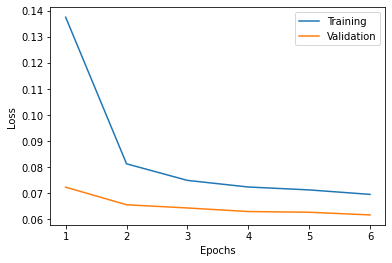

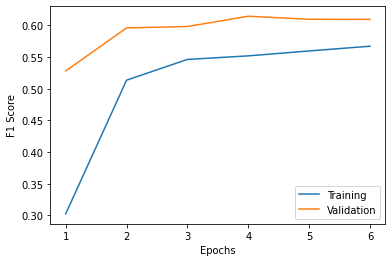

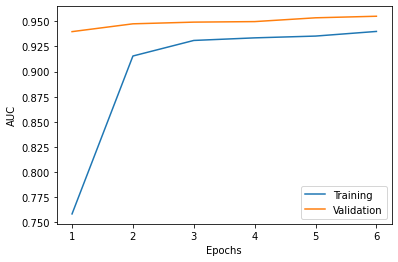

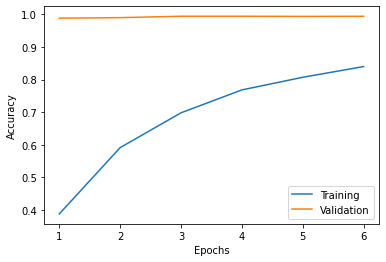

In [ ]:
def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.plot(x_plot, network_history.history['f1_m'])
    plt.plot(x_plot, network_history.history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.plot(x_plot, network_history.history['auc'])
    plt.plot(x_plot, network_history.history['val_auc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    

plot_history(train_history1, 6)

# Unfreeze DistilBERT and Fine-tune All Weights


In [13]:
model.load_weights('/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/models/original_train_model_freeze_w.h5')

In [14]:
# Unfreeze DistilBERT weights to enable fine-tuning
for layer in distilBERT.layers:
    layer.trainable = True

# Lower the learning rate to prevent destruction of pre-trained weights
optimizer = tf.keras.optimizers.Adam(learning_rate=params['FT_LEARNING_RATE'])

auc_score = AUC(multi_label=True)
# Recompile model after unfreezing
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=[auc_score, f1_m, 'accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  min_delta=0,
                                                  patience=2,
                                                  restore_best_weights=True)
##############################

# Train the model
train_history2 = model.fit(
    x = [train_id, train_mask],
    y = y_train.to_numpy(),
    epochs = params['FT_EPOCHS'],
    batch_size = params['BATCH_SIZE'],
    validation_split = 0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/6
1995/1995 [==============================] - 1676s 836ms/step - loss: 0.0498 - auc_1: 0.9647 - f1_m: 0.6910 - accuracy: 0.8987 - val_loss: 0.0415 - val_auc_1: 0.9805 - val_f1_m: 0.7406 - val_accuracy: 0.9941
Epoch 2/6
1995/1995 [==============================] - 1679s 842ms/step - loss: 0.0418 - auc_1: 0.9795 - f1_m: 0.7355 - accuracy: 0.8905 - val_loss: 0.0407 - val_auc_1: 0.9853 - val_f1_m: 0.7664 - val_accuracy: 0.9939
Epoch 3/6
1995/1995 [==============================] - 1680s 842ms/step - loss: 0.0372 - auc_1: 0.9844 - f1_m: 0.7669 - accuracy: 0.8763 - val_loss: 0.0402 - val_auc_1: 0.9848 - val_f1_m: 0.7729 - val_accuracy: 0.9933
Epoch 4/6
1995/1995 [==============================] - 1681s 843ms/step - loss: 0.0335 - auc_1: 0.9862 - f1_m: 0.7897 - accuracy: 0.8531 - val_loss: 0.0417 - val_auc_1: 0.9795 - val_f1_m: 0.7697 - val_accuracy: 0.9931
Epoch 5/6
1995/1995 [==============================] - 1681s 843ms/step - loss: 0.0302 - auc_1: 0.9895 - f1_m: 0.8112 - accuracy

In [15]:
model.save_weights("/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/models/original_train_model_UNfreeze_w.h5")

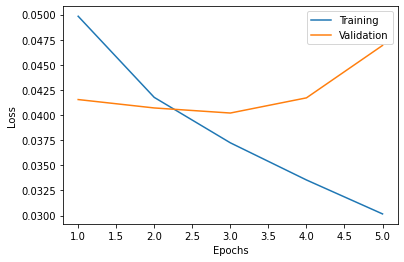

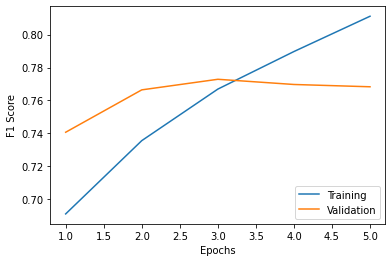

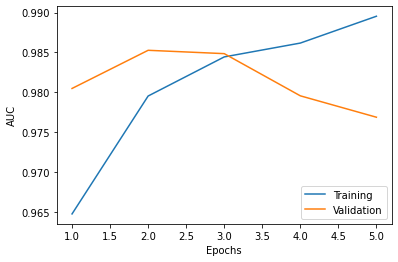

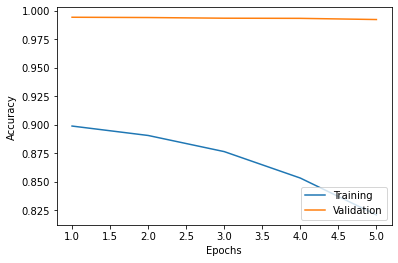

In [18]:
def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.plot(x_plot, network_history.history['f1_m'])
    plt.plot(x_plot, network_history.history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.plot(x_plot, network_history.history['auc_1'])
    plt.plot(x_plot, network_history.history['val_auc_1'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    

plot_history(train_history2, 5)